## Fisher Information for Jampy model.

In [1]:
#General packages
import numpy as np
from My_Jampy import JAM
import matplotlib.pyplot as plt

#Numerical diff
import numdifftools as nd

#Constants and usefull packages
from astropy.cosmology import Planck15 as cosmo
from astropy.constants import G, M_sun, c
import astropy.units as u

#Dataset path
data_folder = "/home/carlos/Documents/GitHub/Master-Degree/Autolens_tests/autolens_workspace/Test_3/Simulation_data/"

In [2]:
surf_lum, sigma_lum, qobs_lum = np.loadtxt("JAM_Input.txt", unpack=True)          #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt("SDP81_pseudo-DM.txt", unpack=True)    #DM component
norm_psf, sigma_psf           = np.loadtxt("MUSE_Psf_model.txt", unpack=True)     #PSF
xbin, ybin, vrms              = np.loadtxt("vrms_data.txt", unpack=True)          #Vrms data

muse_pixsize = 0.2                            #Muse pixel size [arcsec/px]

z_lens   = 0.299                              #Lens redshifth
z_source = 3.100                              #Source redshift

#Angular diameter distances
D_l = cosmo.angular_diameter_distance(z_lens)                   #Lens              
D_s = cosmo.angular_diameter_distance(z_source)                 #Source
D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)   #Lens to source


In [3]:
#Best Fit values
inc       = 77                                #Inclination [deg]
mbh       = 10**(9)                               #Mass of black hole [M_sun]
beta      = np.full_like(surf_lum, -0.55)     #Anisotropy
ml        = 7.7                               #Mass to light ratio [M_sun/L_sun]
rho_s     = 10**8.69                          #dark matter intensity
qdm       = np.full_like(qobs_dm, 1)          #dark matter axial ratio

In [4]:
#--------------------------------------------------------------------------------------------------#
# JAMPY MODEL

Jam_model = JAM(ybin=ybin, xbin=xbin, inc=inc, distance=D_l.value, mbh=mbh, beta=beta, rms=vrms,
               normpsf=norm_psf, sigmapsf=sigma_psf*muse_pixsize, pixsize=muse_pixsize)

    #Add Luminosity component
Jam_model.luminosity_component(surf_lum=surf_lum, sigma_lum=sigma_lum,
                                qobs_lum=qobs_lum, ml=ml)
    #Add DM component
Jam_model.DM_component(surf_dm=rho_s * surf_dm, sigma_dm=sigma_dm, qobs_dm=qdm)

#--------------------------------------------------------------------------------------------------#

/home/carlos/anaconda3/lib/python3.7/site-packages/jampy/legacy/jam_axi_rms.py:281: RuntimeWarning: divide by zero encountered in true_divide
  / signal.fftconvolve(mgeCar, kernel, mode='same')
/home/carlos/anaconda3/lib/python3.7/site-packages/jampy/legacy/jam_axi_rms.py:281: RuntimeWarning: invalid value encountered in true_divide
  / signal.fftconvolve(mgeCar, kernel, mode='same')


jam_axi_rms elapsed time sec: 0.87
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=1
Total mass MGE: 6.823e+11


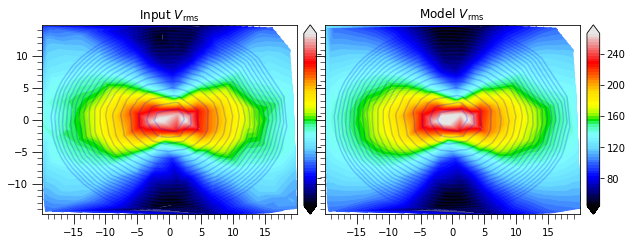

In [5]:
plt.figure(figsize=(10,8))
rmsModel, ml_model, chi2, chi2T = Jam_model.run(plot=True, quiet=False, cmap="sauron")

In [6]:
chi2T*0.5

150.64259453112226

In [7]:
inc       = 77                                #Inclination [deg]
mbh       = 1e9                               #Mass of black hole [M_sun]
beta      = np.full_like(surf_lum, -0.55)     #Anisotropy
ml        = 7.7                               #Mass to light ratio [M_sun/L_sun]
rho_s     = 10**8.69                          #dark matter intensity
qdm       = np.full_like(qobs_dm, 1.0)        #dark matter axial ratio

def neg_log_likelihood(pars):
    inc_model, log_mbh_model, beta_model, ml_model, log_rho_model = pars
    
    beta_model    = np.full_like(surf_lum, beta_model)
    surf_dm_model = (10**log_rho_model) * surf_dm
    qDM_model     = np.full_like(surf_dm, 1.0)
            
    Jam_model = JAM(ybin=ybin, xbin=xbin, inc=inc_model, distance=D_l.value, mbh=10**log_mbh_model, beta=beta_model, rms=vrms,
               normpsf=norm_psf, sigmapsf=sigma_psf*muse_pixsize, pixsize=muse_pixsize)

        #Add Luminosity component
    Jam_model.luminosity_component(surf_lum=surf_lum, sigma_lum=sigma_lum,
                                    qobs_lum=qobs_lum, ml=ml_model)
        #Add DM component
    Jam_model.DM_component(surf_dm=10**(log_rho_model) * surf_dm, sigma_dm=sigma_dm, qobs_dm=qDM_model)
    
    rmsModel, ml_model, chi2, chi2T = Jam_model.run(quiet=False)
    
    return 0.5 * chi2T
    

In [322]:
def neg_log_likelihood2(pars):
    inc_model, mbh_model, beta_model, ml_model, rho_model = pars
    
    beta_model    = np.full_like(surf_lum, beta_model)
    surf_dm_model = (rho_model) * surf_dm
    qDM_model     = np.full_like(surf_dm, 1.0)
            
    Jam_model = JAM(ybin=ybin, xbin=xbin, inc=inc_model, distance=D_l.value, mbh=mbh_model, beta=beta_model, rms=vrms,
               normpsf=norm_psf, sigmapsf=sigma_psf*muse_pixsize, pixsize=muse_pixsize)

        #Add Luminosity component
    Jam_model.luminosity_component(surf_lum=surf_lum, sigma_lum=sigma_lum,
                                    qobs_lum=qobs_lum, ml=ml_model)
        #Add DM component
    Jam_model.DM_component(surf_dm=surf_dm_model, sigma_dm=sigma_dm, qobs_dm=qDM_model)
    
    rmsModel, ml_model, chi2, chi2T = Jam_model.run(quiet=False, plot=False)
    
    
    return 0.5 * chi2T

## Usando valores "reais"

In [327]:
#In order: Inc, mbh, Beta, ML, Log_rho
deltas =np.array([2, 2e9, 1e-1, 1e-1, 1e8])              

hess_         = nd.Hessian(neg_log_likelihood2,deltas, full_output=True)  #Hessian at any point
hess_result, info   = hess_(best_pars2)                                         #Hessian at position best_pars

jam_axi_rms elapsed time sec: 0.79
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=1
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.79
inc=81.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.857
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.78
inc=73.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=1
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.79
inc=79.0 beta_z=-0.55 M/L=1 BH=3.00e+09 chi2/DOF=0.974
Total mass MGE: 6.842e+11
jam_axi_rms elapsed time sec: 0.75
inc=79.0 beta_z=-0.55 M/L=1 BH=-1.00e+09 chi2/DOF=1.11
Total mass MGE: 6.813e+11
jam_axi_rms elapsed time sec: 0.79
inc=75.0 beta_z=-0.55 M/L=1 BH=3.00e+09 chi2/DOF=1.03
Total mass MGE: 6.842e+11
jam_axi_rms elapsed time sec: 0.75
inc=75.0 beta_z=-0.55 M/L=1 BH=-1.00e+09 chi2/DOF=1.04
Total mass MGE: 6.813e+11
jam_axi_rms elapsed time sec: 0.80
inc=79.0 beta_z=-0.45 M/L=1 BH=1.00e+09 chi2/DOF=1.18
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.81
inc=79.0 beta_z=-0.65 M/L=1 BH=1.00e+09 chi2/DO

In [328]:
print("Hess. Matrix")
with np.printoptions(formatter={'float': '{: 0.3e}'.format}, suppress=True):
    print((hess_result))

Hess. Matrix
[[-1.407e+00 -1.224e-09 -2.982e+01  1.384e+00 -6.794e-10]
 [-1.224e-09 -1.647e-18 -1.587e-08 -2.269e-08 -1.403e-17]
 [-2.982e+01 -1.587e-08  3.904e+03 -1.709e+03 -7.185e-07]
 [ 1.384e+00 -2.269e-08 -1.709e+03 -1.153e+02  1.386e-08]
 [-6.794e-10 -1.403e-17 -7.185e-07  1.386e-08 -6.267e-16]]


In [329]:
np.linalg.eigvals(hess_result)

array([ 4.53266494e+03, -7.43981157e+02, -1.47641205e+00, -6.51251475e-16,
       -5.31358112e-15])

In [330]:
#In order: Inc, Log_mbh, Beta, ML, Log_rho
print("Error estimate in  Hess.")
with np.printoptions(formatter={'float': '{: 0.3e}'.format}, suppress=True):
    print(info[0])

Error estimate in  Hess.
[[ 2.541e+01  2.541e+10  1.271e+00  1.271e+00  1.271e+09]
 [ 2.541e+01  2.541e+10  1.271e+00  1.271e+00  1.271e+09]
 [ 2.541e+01  2.541e+10  1.271e+00  1.271e+00  1.271e+09]
 [ 2.541e+01  2.541e+10  1.271e+00  1.271e+00  1.271e+09]
 [ 2.541e+01  2.541e+10  1.271e+00  1.271e+00  1.271e+09]]


In [331]:
#In order: Inc, Log_mbh, Beta, ML, Log_rho
print("Cov. Matrix")
with np.printoptions(formatter={'float': '{: 0.3e}'.format}, suppress=True):
    print((np.linalg.inv(hess_result)))

Cov. Matrix
[[-9.160e+00  1.350e+10 -1.671e-01 -3.020e-01 -1.073e+08]
 [ 1.350e+10 -2.148e+19  2.642e+08  4.941e+08  1.742e+17]
 [-1.671e-01  2.642e+08 -3.218e-03 -6.553e-03 -2.187e+06]
 [-3.020e-01  4.941e+08 -6.553e-03 -1.281e-02 -3.502e+06]
 [-1.073e+08  1.742e+17 -2.187e+06 -3.502e+06 -2.948e+15]]


# Usando log de alguns valores

In [10]:
#In order: Inc, Log_mbh, Beta, ML, Log_rho
best_pars = np.array([inc, np.log10(mbh), beta[0], ml, np.log10(rho_s)])

## forward

In [289]:
hess_         = nd.Hessian(neg_log_likelihood,method='forward', full_output=True)  #Hessian at any point
hess_result, info   = hess_(best_pars)                                         #Hessian at position best_pars

jam_axi_rms elapsed time sec: 0.79
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=1
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.79
inc=85.7 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.883
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.86
inc=77.0 beta_z=-0.55 M/L=1 BH=4.03e+13 chi2/DOF=2.7e+04
Total mass MGE: 4.093e+13
jam_axi_rms elapsed time sec: 0.79
inc=77.0 beta_z=1.45 M/L=1 BH=1.00e+09 chi2/DOF=323
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.79
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=26.5
Total mass MGE: 1.059e+12
jam_axi_rms elapsed time sec: 0.73
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=4.03e+04
Total mass MGE: 3.607e+14
jam_axi_rms elapsed time sec: 0.78
inc=94.4 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.843
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.86
inc=85.7 beta_z=-0.55 M/L=1 BH=4.03e+13 chi2/DOF=2.75e+04
Total mass MGE: 4.093e+13
jam_axi_rms elapsed time sec: 0.79
inc=85.7 beta_z=1.45 M/L=1 BH=1.00e+0

jam_axi_rms elapsed time sec: 0.84
inc=77.0 beta_z=-0.55 M/L=1 BH=1.77e+11 chi2/DOF=11.9
Total mass MGE: 8.583e+11
jam_axi_rms elapsed time sec: 0.81
inc=77.0 beta_z=-0.06 M/L=1 BH=1.33e+10 chi2/DOF=9.68
Total mass MGE: 6.946e+11
jam_axi_rms elapsed time sec: 0.81
inc=77.0 beta_z=-0.55 M/L=1 BH=1.33e+10 chi2/DOF=2.96
Total mass MGE: 7.866e+11
jam_axi_rms elapsed time sec: 0.81
inc=77.0 beta_z=-0.55 M/L=1 BH=1.33e+10 chi2/DOF=1
Total mass MGE: 8.17e+11
jam_axi_rms elapsed time sec: 0.83
inc=77.0 beta_z=0.43 M/L=1 BH=1.00e+09 chi2/DOF=325
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.82
inc=77.0 beta_z=-0.06 M/L=1 BH=1.00e+09 chi2/DOF=5.48
Total mass MGE: 7.743e+11
jam_axi_rms elapsed time sec: 0.79
inc=77.0 beta_z=-0.06 M/L=1 BH=1.00e+09 chi2/DOF=8.66
Total mass MGE: 8.047e+11
jam_axi_rms elapsed time sec: 0.79
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=7.17
Total mass MGE: 8.663e+11
jam_axi_rms elapsed time sec: 0.79
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=3.

jam_axi_rms elapsed time sec: 0.86
inc=77.0 beta_z=-0.48 M/L=1 BH=1.00e+09 chi2/DOF=1.13
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.90
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.833
Total mass MGE: 6.963e+11
jam_axi_rms elapsed time sec: 0.81
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.858
Total mass MGE: 6.872e+11
jam_axi_rms elapsed time sec: 0.87
inc=77.6 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.963
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.87
inc=77.3 beta_z=-0.55 M/L=1 BH=1.48e+09 chi2/DOF=0.868
Total mass MGE: 6.827e+11
jam_axi_rms elapsed time sec: 0.90
inc=77.3 beta_z=-0.48 M/L=1 BH=1.00e+09 chi2/DOF=1.2
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 1.06
inc=77.3 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.866
Total mass MGE: 6.963e+11
jam_axi_rms elapsed time sec: 1.04
inc=77.3 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.87
Total mass MGE: 6.872e+11
jam_axi_rms elapsed time sec: 1.15
inc=77.0 beta_z=-0.55 M/L=1 BH=2.20e+09 c

jam_axi_rms elapsed time sec: 0.83
inc=77.0 beta_z=-0.55 M/L=1 BH=1.10e+09 chi2/DOF=0.944
Total mass MGE: 6.834e+11
jam_axi_rms elapsed time sec: 0.83
inc=77.0 beta_z=-0.51 M/L=1 BH=1.00e+09 chi2/DOF=1.04
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.90
inc=77.0 beta_z=-0.53 M/L=1 BH=1.00e+09 chi2/DOF=0.994
Total mass MGE: 6.857e+11
jam_axi_rms elapsed time sec: 0.83
inc=77.0 beta_z=-0.53 M/L=1 BH=1.00e+09 chi2/DOF=0.959
Total mass MGE: 6.833e+11
jam_axi_rms elapsed time sec: 0.83
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.917
Total mass MGE: 6.891e+11
jam_axi_rms elapsed time sec: 0.83
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.846
Total mass MGE: 6.867e+11
jam_axi_rms elapsed time sec: 0.83
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.885
Total mass MGE: 6.844e+11
jam_axi_rms elapsed time sec: 0.83
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.945
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.82
inc=77.0 beta_z=-0.55 M/L=1 BH=1.06e+0

jam_axi_rms elapsed time sec: 0.89
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.891
Total mass MGE: 6.824e+11
jam_axi_rms elapsed time sec: 0.89
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=1.3
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.89
inc=77.0 beta_z=-0.55 M/L=1 BH=1.01e+09 chi2/DOF=0.917
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.90
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.948
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.95
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=1.1
Total mass MGE: 6.828e+11
jam_axi_rms elapsed time sec: 0.89
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.917
Total mass MGE: 6.824e+11
jam_axi_rms elapsed time sec: 0.89
inc=77.0 beta_z=-0.55 M/L=1 BH=1.03e+09 chi2/DOF=1.07
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.89
inc=77.0 beta_z=-0.55 M/L=1 BH=1.01e+09 chi2/DOF=0.927
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.89
inc=77.0 beta_z=-0.55 M/L=1 BH=1.01e+09 ch

In [290]:
print("Hess. Matrix")
with np.printoptions(formatter={'float': '{: 0.3e}'.format}, suppress=True):
    print((hess_result))

Hess. Matrix
[[ 3.048e+02  6.300e+02 -1.564e+02  5.792e-01  4.534e+01]
 [ 6.300e+02  2.354e+03  3.163e+03  2.275e+02  2.192e+00]
 [-1.564e+02  3.163e+03  1.055e+04 -5.337e+01  2.779e+02]
 [ 5.792e-01  2.275e+02 -5.337e+01  5.214e+02  1.570e+03]
 [ 4.534e+01  2.192e+00  2.779e+02  1.570e+03  1.916e+03]]


In [291]:
np.linalg.eigvals(hess_result)

array([11638.08163261,  -551.55507133,    12.42181353,  1615.82856158,
        2932.90732801])

In [292]:
#In order: Inc, Log_mbh, Beta, ML, Log_rho
print("Error estimate in  Hess.")
with np.printoptions(formatter={'float': '{: 0.3e}'.format}, suppress=True):
    print(info[0])

Error estimate in  Hess.
[[ 4.017e+02  6.111e+02  2.055e+03  1.119e+03  7.166e+02]
 [ 6.111e+02  1.581e+03  2.436e+03  5.940e+02  2.212e+03]
 [ 2.055e+03  2.436e+03  1.666e+04  4.310e+03  2.757e+03]
 [ 1.119e+03  5.940e+02  4.310e+03  4.944e+02  1.677e+03]
 [ 7.166e+02  2.212e+03  2.757e+03  1.677e+03  1.063e+04]]


In [293]:
#In order: Inc, Log_mbh, Beta, ML, Log_rho
print("Cov. Matrix")
with np.printoptions(formatter={'float': '{: 0.3e}'.format}, suppress=True):
    print((np.linalg.inv(hess_result)))

Cov. Matrix
[[ 6.283e-02 -2.726e-02  8.796e-03 -1.429e-02  8.973e-03]
 [-2.726e-02  1.248e-02 -4.006e-03  6.461e-03 -4.082e-03]
 [ 8.796e-03 -4.006e-03  1.381e-03 -2.111e-03  1.326e-03]
 [-1.429e-02  6.461e-03 -2.111e-03  2.059e-03 -1.050e-03]
 [ 8.973e-03 -4.082e-03  1.326e-03 -1.050e-03  9.821e-04]]


## central

In [294]:

hess_         = nd.Hessian(neg_log_likelihood,full_output=True)  #Hessian at any point
hess_result, info   = hess_(best_pars)                                         #Hessian at position best_pars

/home/carlos/anaconda3/lib/python3.7/site-packages/jampy/legacy/jam_axi_rms.py:281: RuntimeWarning: divide by zero encountered in true_divide
  / signal.fftconvolve(mgeCar, kernel, mode='same')
/home/carlos/anaconda3/lib/python3.7/site-packages/jampy/legacy/jam_axi_rms.py:281: RuntimeWarning: invalid value encountered in true_divide
  / signal.fftconvolve(mgeCar, kernel, mode='same')


jam_axi_rms elapsed time sec: 0.81
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=1
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.80
inc=94.4 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.843
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.81
inc=59.6 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=2.91
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.86
inc=85.7 beta_z=-0.55 M/L=1 BH=4.03e+13 chi2/DOF=2.75e+04
Total mass MGE: 4.093e+13
jam_axi_rms elapsed time sec: 0.78
inc=85.7 beta_z=-0.55 M/L=1 BH=2.48e+04 chi2/DOF=0.923
Total mass MGE: 6.813e+11
jam_axi_rms elapsed time sec: 0.90
inc=68.3 beta_z=-0.55 M/L=1 BH=4.03e+13 chi2/DOF=2.53e+04
Total mass MGE: 4.093e+13
jam_axi_rms elapsed time sec: 0.87
inc=68.3 beta_z=-0.55 M/L=1 BH=2.48e+04 chi2/DOF=1.38
Total mass MGE: 6.813e+11
jam_axi_rms elapsed time sec: 0.82
inc=85.7 beta_z=1.45 M/L=1 BH=1.00e+09 chi2/DOF=363
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.80
inc=85.7 beta_z=-2.55 M/L=1 BH=1.00e+09 

jam_axi_rms elapsed time sec: 1.02
inc=77.0 beta_z=0.70 M/L=1 BH=7.55e+11 chi2/DOF=455
Total mass MGE: 1.436e+12
jam_axi_rms elapsed time sec: 0.88
inc=77.0 beta_z=-1.80 M/L=1 BH=7.55e+11 chi2/DOF=221
Total mass MGE: 1.436e+12
jam_axi_rms elapsed time sec: 0.81
inc=77.0 beta_z=0.70 M/L=1 BH=1.32e+06 chi2/DOF=414
Total mass MGE: 6.813e+11
jam_axi_rms elapsed time sec: 0.78
inc=77.0 beta_z=-1.80 M/L=1 BH=1.32e+06 chi2/DOF=5.88
Total mass MGE: 6.813e+11
jam_axi_rms elapsed time sec: 0.86
inc=77.0 beta_z=-0.55 M/L=1 BH=7.55e+11 chi2/DOF=206
Total mass MGE: 1.672e+12
jam_axi_rms elapsed time sec: 0.99
inc=77.0 beta_z=-0.55 M/L=1 BH=7.55e+11 chi2/DOF=100
Total mass MGE: 1.2e+12
jam_axi_rms elapsed time sec: 0.90
inc=77.0 beta_z=-0.55 M/L=1 BH=1.32e+06 chi2/DOF=11.2
Total mass MGE: 9.169e+11
jam_axi_rms elapsed time sec: 0.94
inc=77.0 beta_z=-0.55 M/L=1 BH=1.32e+06 chi2/DOF=19.6
Total mass MGE: 4.456e+11
jam_axi_rms elapsed time sec: 0.98
inc=77.0 beta_z=-0.55 M/L=1 BH=7.55e+11 chi2/DOF=574
T

jam_axi_rms elapsed time sec: 0.84
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=16.9
Total mass MGE: 9.768e+11
jam_axi_rms elapsed time sec: 0.90
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=31
Total mass MGE: 3.877e+11
jam_axi_rms elapsed time sec: 0.91
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=15.1
Total mass MGE: 1.434e+12
jam_axi_rms elapsed time sec: 1.03
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=4.75
Total mass MGE: 8.194e+11
jam_axi_rms elapsed time sec: 0.88
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=2.5
Total mass MGE: 1.139e+12
jam_axi_rms elapsed time sec: 0.90
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=8.1
Total mass MGE: 5.248e+11
jam_axi_rms elapsed time sec: 0.93
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=2.81e+03
Total mass MGE: 3.721e+13
jam_axi_rms elapsed time sec: 0.91
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.967
Total mass MGE: 6.719e+11
jam_axi_rms elapsed time sec: 0.92
inc=81.3 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2

jam_axi_rms elapsed time sec: 1.19
inc=78.3 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.878
Total mass MGE: 7.229e+11
jam_axi_rms elapsed time sec: 1.09
inc=78.3 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.948
Total mass MGE: 6.74e+11
jam_axi_rms elapsed time sec: 1.18
inc=75.7 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.916
Total mass MGE: 7.229e+11
jam_axi_rms elapsed time sec: 1.03
inc=75.7 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.911
Total mass MGE: 6.74e+11
jam_axi_rms elapsed time sec: 0.93
inc=77.0 beta_z=-0.55 M/L=1 BH=2.54e+10 chi2/DOF=0.991
Total mass MGE: 7.067e+11
jam_axi_rms elapsed time sec: 0.85
inc=77.0 beta_z=-0.55 M/L=1 BH=3.93e+07 chi2/DOF=1.02
Total mass MGE: 6.813e+11
jam_axi_rms elapsed time sec: 0.94
inc=77.0 beta_z=-0.24 M/L=1 BH=5.04e+09 chi2/DOF=3.57
Total mass MGE: 6.863e+11
jam_axi_rms elapsed time sec: 0.87
inc=77.0 beta_z=-0.86 M/L=1 BH=5.04e+09 chi2/DOF=1.54
Total mass MGE: 6.863e+11
jam_axi_rms elapsed time sec: 0.94
inc=77.0 beta_z=-0.24 M/L=1 BH=1.98e+08 ch

jam_axi_rms elapsed time sec: 0.93
inc=77.0 beta_z=-0.74 M/L=1 BH=1.00e+09 chi2/DOF=1.84
Total mass MGE: 7.182e+11
jam_axi_rms elapsed time sec: 1.08
inc=77.0 beta_z=-0.74 M/L=1 BH=1.00e+09 chi2/DOF=0.906
Total mass MGE: 6.463e+11
jam_axi_rms elapsed time sec: 1.56
inc=77.0 beta_z=-0.36 M/L=1 BH=1.00e+09 chi2/DOF=1.83
Total mass MGE: 6.999e+11
jam_axi_rms elapsed time sec: 1.26
inc=77.0 beta_z=-0.36 M/L=1 BH=1.00e+09 chi2/DOF=1.99
Total mass MGE: 6.757e+11
jam_axi_rms elapsed time sec: 1.57
inc=77.0 beta_z=-0.74 M/L=1 BH=1.00e+09 chi2/DOF=1.04
Total mass MGE: 6.999e+11
jam_axi_rms elapsed time sec: 1.42
inc=77.0 beta_z=-0.74 M/L=1 BH=1.00e+09 chi2/DOF=1
Total mass MGE: 6.757e+11
jam_axi_rms elapsed time sec: 1.00
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=1.64
Total mass MGE: 7.542e+11
jam_axi_rms elapsed time sec: 0.91
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=2.72
Total mass MGE: 6.103e+11
jam_axi_rms elapsed time sec: 0.98
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DO

jam_axi_rms elapsed time sec: 0.95
inc=76.7 beta_z=-0.48 M/L=1 BH=1.00e+09 chi2/DOF=1.15
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.88
inc=76.7 beta_z=-0.62 M/L=1 BH=1.00e+09 chi2/DOF=0.831
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.89
inc=77.3 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.866
Total mass MGE: 6.963e+11
jam_axi_rms elapsed time sec: 0.86
inc=77.3 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=1.12
Total mass MGE: 6.682e+11
jam_axi_rms elapsed time sec: 0.95
inc=76.7 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.91
Total mass MGE: 6.963e+11
jam_axi_rms elapsed time sec: 0.93
inc=76.7 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=1.02
Total mass MGE: 6.682e+11
jam_axi_rms elapsed time sec: 0.89
inc=77.3 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.87
Total mass MGE: 6.872e+11
jam_axi_rms elapsed time sec: 0.86
inc=77.3 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.866
Total mass MGE: 6.789e+11
jam_axi_rms elapsed time sec: 0.86
inc=76.7 beta_z=-0.55 M/L=1 BH=1.00e+09 ch

jam_axi_rms elapsed time sec: 0.97
inc=77.0 beta_z=-0.55 M/L=1 BH=7.81e+08 chi2/DOF=1.07
Total mass MGE: 6.849e+11
jam_axi_rms elapsed time sec: 1.03
inc=77.0 beta_z=-0.55 M/L=1 BH=7.81e+08 chi2/DOF=1.1
Total mass MGE: 6.798e+11
jam_axi_rms elapsed time sec: 0.87
inc=77.0 beta_z=-0.46 M/L=1 BH=1.00e+09 chi2/DOF=1.22
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 1.00
inc=77.0 beta_z=-0.64 M/L=1 BH=1.00e+09 chi2/DOF=0.88
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 1.13
inc=77.0 beta_z=-0.50 M/L=1 BH=1.00e+09 chi2/DOF=1.03
Total mass MGE: 6.91e+11
jam_axi_rms elapsed time sec: 0.95
inc=77.0 beta_z=-0.50 M/L=1 BH=1.00e+09 chi2/DOF=1.18
Total mass MGE: 6.735e+11
jam_axi_rms elapsed time sec: 0.98
inc=77.0 beta_z=-0.60 M/L=1 BH=1.00e+09 chi2/DOF=1.02
Total mass MGE: 6.91e+11
jam_axi_rms elapsed time sec: 1.06
inc=77.0 beta_z=-0.60 M/L=1 BH=1.00e+09 chi2/DOF=0.865
Total mass MGE: 6.735e+11
jam_axi_rms elapsed time sec: 1.01
inc=77.0 beta_z=-0.50 M/L=1 BH=1.00e+09 chi2/DO

jam_axi_rms elapsed time sec: 1.48
inc=77.1 beta_z=-0.55 M/L=1 BH=1.10e+09 chi2/DOF=1.05
Total mass MGE: 6.824e+11
jam_axi_rms elapsed time sec: 1.85
inc=77.1 beta_z=-0.55 M/L=1 BH=9.08e+08 chi2/DOF=0.902
Total mass MGE: 6.822e+11
jam_axi_rms elapsed time sec: 1.65
inc=76.9 beta_z=-0.55 M/L=1 BH=1.10e+09 chi2/DOF=0.994
Total mass MGE: 6.824e+11
jam_axi_rms elapsed time sec: 1.30
inc=76.9 beta_z=-0.55 M/L=1 BH=9.08e+08 chi2/DOF=0.882
Total mass MGE: 6.822e+11
jam_axi_rms elapsed time sec: 0.99
inc=77.1 beta_z=-0.53 M/L=1 BH=1.00e+09 chi2/DOF=0.979
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.88
inc=77.1 beta_z=-0.57 M/L=1 BH=1.00e+09 chi2/DOF=0.869
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.86
inc=76.9 beta_z=-0.53 M/L=1 BH=1.00e+09 chi2/DOF=0.93
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.90
inc=76.9 beta_z=-0.57 M/L=1 BH=1.00e+09 chi2/DOF=0.851
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.98
inc=77.1 beta_z=-0.55 M/L=1 BH=1.00e+09

jam_axi_rms elapsed time sec: 1.18
inc=77.0 beta_z=-0.56 M/L=1 BH=9.42e+08 chi2/DOF=0.892
Total mass MGE: 6.822e+11
jam_axi_rms elapsed time sec: 0.99
inc=77.0 beta_z=-0.55 M/L=1 BH=1.06e+09 chi2/DOF=1.01
Total mass MGE: 6.845e+11
jam_axi_rms elapsed time sec: 1.18
inc=77.0 beta_z=-0.55 M/L=1 BH=1.06e+09 chi2/DOF=1.01
Total mass MGE: 6.802e+11
jam_axi_rms elapsed time sec: 0.90
inc=77.0 beta_z=-0.55 M/L=1 BH=9.42e+08 chi2/DOF=0.86
Total mass MGE: 6.843e+11
jam_axi_rms elapsed time sec: 0.87
inc=77.0 beta_z=-0.55 M/L=1 BH=9.42e+08 chi2/DOF=1
Total mass MGE: 6.801e+11
jam_axi_rms elapsed time sec: 0.95
inc=77.0 beta_z=-0.55 M/L=1 BH=1.06e+09 chi2/DOF=0.862
Total mass MGE: 6.829e+11
jam_axi_rms elapsed time sec: 0.91
inc=77.0 beta_z=-0.55 M/L=1 BH=1.06e+09 chi2/DOF=0.949
Total mass MGE: 6.817e+11
jam_axi_rms elapsed time sec: 0.96
inc=77.0 beta_z=-0.55 M/L=1 BH=9.42e+08 chi2/DOF=0.89
Total mass MGE: 6.828e+11
jam_axi_rms elapsed time sec: 1.02
inc=77.0 beta_z=-0.55 M/L=1 BH=9.42e+08 chi2/

jam_axi_rms elapsed time sec: 0.99
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.88
Total mass MGE: 6.84e+11
jam_axi_rms elapsed time sec: 0.99
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.908
Total mass MGE: 6.832e+11
jam_axi_rms elapsed time sec: 1.12
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.987
Total mass MGE: 6.813e+11
jam_axi_rms elapsed time sec: 0.97
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.888
Total mass MGE: 6.805e+11
jam_axi_rms elapsed time sec: 1.26
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.956
Total mass MGE: 6.83e+11
jam_axi_rms elapsed time sec: 0.87
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=1.07
Total mass MGE: 6.815e+11
jam_axi_rms elapsed time sec: 0.88
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.903
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.88
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.906
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.88
inc=77.0 beta_z=-0.55 M/L=1 BH=1.02e+09 c

jam_axi_rms elapsed time sec: 0.88
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.936
Total mass MGE: 6.821e+11
jam_axi_rms elapsed time sec: 0.93
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.909
Total mass MGE: 6.824e+11
jam_axi_rms elapsed time sec: 0.86
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.918
Total mass MGE: 6.821e+11
jam_axi_rms elapsed time sec: 0.92
inc=77.0 beta_z=-0.55 M/L=1 BH=1.03e+09 chi2/DOF=1.07
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.91
inc=77.0 beta_z=-0.55 M/L=1 BH=9.71e+08 chi2/DOF=0.869
Total mass MGE: 6.822e+11
jam_axi_rms elapsed time sec: 0.90
inc=77.0 beta_z=-0.55 M/L=1 BH=1.01e+09 chi2/DOF=0.927
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.95
inc=77.0 beta_z=-0.55 M/L=1 BH=1.01e+09 chi2/DOF=0.905
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.86
inc=77.0 beta_z=-0.55 M/L=1 BH=9.85e+08 chi2/DOF=0.898
Total mass MGE: 6.822e+11
jam_axi_rms elapsed time sec: 0.90
inc=77.0 beta_z=-0.55 M/L=1 BH=9.85e+0

In [295]:
print("Hess. Matrix")
with np.printoptions(formatter={'float': '{: 0.3e}'.format}, suppress=True):
    print((hess_result))

Hess. Matrix
[[ 1.059e+00 -1.697e+00  1.009e+01  1.963e+01  2.445e+01]
 [-1.697e+00 -3.797e+01 -5.645e+01  3.852e+01  2.954e+01]
 [ 1.009e+01 -5.645e+01 -4.792e+02 -1.383e+03 -6.264e+01]
 [ 1.963e+01  3.852e+01 -1.383e+03  5.180e+02  2.001e+01]
 [ 2.445e+01  2.954e+01 -6.264e+01  2.001e+01  2.777e+01]]


In [296]:
np.linalg.eigvals(hess_result)

array([ 1494.59899952, -1452.80443428,    47.10302929,    -6.68333385,
         -52.55208715])

In [297]:
print("Error estimate in  Hess.")
with np.printoptions(formatter={'float': '{: 0.3e}'.format}, suppress=True):
    print(info[0])

Error estimate in  Hess.
[[ 1.882e+01  4.134e+01  8.442e+01  3.454e+01  7.471e+01]
 [ 4.134e+01  8.874e+02  5.851e+01  2.537e+02  1.200e+01]
 [ 8.442e+01  5.851e+01  4.875e+03  1.407e+02  8.862e+01]
 [ 3.454e+01  2.537e+02  1.407e+02  5.153e+01  2.049e+02]
 [ 7.471e+01  1.200e+01  8.862e+01  2.049e+02  8.668e+02]]


In [300]:
print("Cov. Matrix")
with np.printoptions(formatter={'float': '{: 0.3e}'.format}, suppress=True):
    print((np.linalg.inv(hess_result)))

Cov. Matrix
[[-1.126e-01  4.361e-02 -1.318e-03 -4.544e-03  5.300e-02]
 [ 4.361e-02 -3.134e-02  3.169e-04  1.740e-03 -5.593e-03]
 [-1.318e-03  3.169e-04 -2.574e-04 -6.897e-04  7.392e-04]
 [-4.544e-03  1.740e-03 -6.897e-04  1.115e-04  5.127e-04]
 [ 5.300e-02 -5.593e-03  7.392e-04  5.127e-04 -3.401e-03]]


## 10% central

In [11]:
deltas = best_pars*0.1
hess_         = nd.Hessian(neg_log_likelihood, deltas, full_output=True)  #Hessian at any point
hess_result, info   = hess_(best_pars)                                         #Hessian at position best_pars

/home/carlos/anaconda3/lib/python3.7/site-packages/jampy/legacy/jam_axi_rms.py:281: RuntimeWarning: divide by zero encountered in true_divide
  / signal.fftconvolve(mgeCar, kernel, mode='same')
/home/carlos/anaconda3/lib/python3.7/site-packages/jampy/legacy/jam_axi_rms.py:281: RuntimeWarning: invalid value encountered in true_divide
  / signal.fftconvolve(mgeCar, kernel, mode='same')


jam_axi_rms elapsed time sec: 0.87
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=1
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.84
inc=92.4 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.947
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.82
inc=61.6 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=2.4
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.78
inc=84.7 beta_z=-0.55 M/L=1 BH=7.94e+09 chi2/DOF=0.908
Total mass MGE: 6.892e+11
jam_axi_rms elapsed time sec: 0.78
inc=84.7 beta_z=-0.55 M/L=1 BH=1.26e+08 chi2/DOF=0.861
Total mass MGE: 6.814e+11
jam_axi_rms elapsed time sec: 0.83
inc=69.3 beta_z=-0.55 M/L=1 BH=7.94e+09 chi2/DOF=1.19
Total mass MGE: 6.892e+11
jam_axi_rms elapsed time sec: 0.76
inc=69.3 beta_z=-0.55 M/L=1 BH=1.26e+08 chi2/DOF=1.27
Total mass MGE: 6.814e+11
jam_axi_rms elapsed time sec: 0.83
inc=84.7 beta_z=-0.61 M/L=1 BH=1.00e+09 chi2/DOF=1.08
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.79
inc=84.7 beta_z=-0.49 M/L=1 BH=1.00e+09 chi2/D

In [12]:
print("Hess. Matrix")
with np.printoptions(formatter={'float': '{: 0.3e}'.format}, suppress=True):
    print((hess_result))

Hess. Matrix
[[ 8.470e-01  7.310e-01 -5.392e+01  1.886e+01  3.531e+00]
 [ 7.310e-01  4.780e+01 -5.295e+00  2.792e+01  5.488e+00]
 [-5.392e+01 -5.295e+00  7.865e+03 -1.396e+03 -2.004e+02]
 [ 1.886e+01  2.792e+01 -1.396e+03  5.563e+02  4.875e+01]
 [ 3.531e+00  5.488e+00 -2.004e+02  4.875e+01  1.451e+02]]


In [13]:
np.linalg.eigvals(hess_result)

array([8.12877365e+03, 3.02532067e+02, 1.74807455e-01, 1.39098048e+02,
       4.48553860e+01])

In [14]:
print("Error estimate in  Hess.")
with np.printoptions(formatter={'float': '{: 0.3e}'.format}, suppress=True):
    print(info[0])

Error estimate in  Hess.
[[ 9.784e+01  1.144e+01 -6.988e-01  9.784e+00  1.104e+01]
 [ 9.784e+01  1.144e+01 -6.988e-01  9.784e+00  1.104e+01]
 [ 9.784e+01  1.144e+01 -6.988e-01  9.784e+00  1.104e+01]
 [ 9.784e+01  1.144e+01 -6.988e-01  9.784e+00  1.104e+01]
 [ 9.784e+01  1.144e+01 -6.988e-01  9.784e+00  1.104e+01]]


In [15]:
print("Cov. Matrix")
with np.printoptions(formatter={'float': '{: 0.3e}'.format}, suppress=True):
    print((np.linalg.inv(hess_result)))

Cov. Matrix
[[ 5.714e+00  2.151e-02  7.012e-03 -1.708e-01 -7.279e-02]
 [ 2.151e-02  2.215e-02 -3.134e-04 -2.545e-03 -9.387e-04]
 [ 7.012e-03 -3.134e-04  2.455e-04  3.899e-04  4.920e-05]
 [-1.708e-01 -2.545e-03  3.899e-04  8.525e-03  1.927e-03]
 [-7.279e-02 -9.387e-04  4.920e-05  1.927e-03  8.118e-03]]


## 10% forward

In [16]:
deltas = best_pars*0.1
hess_         = nd.Hessian(neg_log_likelihood,deltas,method='forward', full_output=True)  #Hessian at any point
hess_result, info   = hess_(best_pars)   

/home/carlos/anaconda3/lib/python3.7/site-packages/numdifftools/core.py:1020: UserWarning: Can not change order to 2! The only valid order is 1 for method=forward.
  warnings.warn(msg.format(order, valid_order, self.method))
/home/carlos/anaconda3/lib/python3.7/site-packages/jampy/legacy/jam_axi_rms.py:281: RuntimeWarning: divide by zero encountered in true_divide
  / signal.fftconvolve(mgeCar, kernel, mode='same')
/home/carlos/anaconda3/lib/python3.7/site-packages/jampy/legacy/jam_axi_rms.py:281: RuntimeWarning: invalid value encountered in true_divide
  / signal.fftconvolve(mgeCar, kernel, mode='same')


jam_axi_rms elapsed time sec: 0.82
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=1
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.81
inc=89.3 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.889
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.83
inc=77.0 beta_z=-0.55 M/L=1 BH=2.75e+10 chi2/DOF=1.11
Total mass MGE: 7.088e+11
jam_axi_rms elapsed time sec: 0.79
inc=77.0 beta_z=-0.64 M/L=1 BH=1.00e+09 chi2/DOF=0.81
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.80
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=2.81
Total mass MGE: 7.896e+11
jam_axi_rms elapsed time sec: 0.78
inc=77.0 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=1.33
Total mass MGE: 9.258e+11
jam_axi_rms elapsed time sec: 0.79
inc=101.6 beta_z=-0.55 M/L=1 BH=1.00e+09 chi2/DOF=0.883
Total mass MGE: 6.823e+11
jam_axi_rms elapsed time sec: 0.82
inc=89.3 beta_z=-0.55 M/L=1 BH=2.75e+10 chi2/DOF=1.33
Total mass MGE: 7.088e+11
jam_axi_rms elapsed time sec: 0.83
inc=89.3 beta_z=-0.64 M/L=1 BH=1.00e+09 chi2/

In [17]:
print("Hess. Matrix")
with np.printoptions(formatter={'float': '{: 0.3e}'.format}, suppress=True):
    print((hess_result))

Hess. Matrix
[[ 2.076e+00  1.098e+01 -3.478e+02  5.384e+01  1.639e+01]
 [ 1.098e+01 -1.640e+04 -8.595e+01 -1.375e+01  6.797e+01]
 [-3.478e+02 -8.595e+01  7.248e+04 -3.123e+03 -5.792e+02]
 [ 5.384e+01 -1.375e+01 -3.123e+03  5.338e+02 -7.188e+01]
 [ 1.639e+01  6.797e+01 -5.792e+02 -7.188e+01 -2.904e+04]]


In [18]:
np.linalg.eigvals(hess_result)

array([ 7.26191778e+04, -3.31487742e+00,  4.02523917e+02, -2.90444497e+04,
       -1.63999749e+04])

In [19]:
print("Error estimate in  Hess.")
with np.printoptions(formatter={'float': '{: 0.3e}'.format}, suppress=True):
    print(info[0])

Error estimate in  Hess.
[[ 9.829e+01  4.041e+02  1.522e+04  2.144e+03  5.775e+02]
 [ 4.041e+02  1.332e+06  3.575e+04  7.560e+03  7.331e+02]
 [ 1.522e+04  3.575e+04  3.255e+06  7.657e+04  9.818e+03]
 [ 2.144e+03  7.560e+03  7.657e+04  1.911e+03  1.467e+04]
 [ 5.775e+02  7.331e+02  9.818e+03  1.467e+04  2.371e+06]]


In [20]:
print("Cov. Matrix")
with np.printoptions(formatter={'float': '{: 0.3e}'.format}, suppress=True):
    print((np.linalg.inv(hess_result)))

Cov. Matrix
[[-2.989e-01 -2.244e-04 -1.859e-04  2.902e-02 -2.374e-04]
 [-2.244e-04 -6.114e-05 -3.292e-07  1.909e-05 -3.105e-07]
 [-1.859e-04 -3.292e-07  1.832e-05  1.258e-04 -7.826e-07]
 [ 2.902e-02  1.909e-05  1.258e-04 -3.144e-04  1.469e-05]
 [-2.374e-04 -3.105e-07 -7.826e-07  1.469e-05 -3.459e-05]]
